# Aerobic Dynamic Flux Balance Analysis (dFBA) using COBRAme

In [1]:
import cobra
#from cobra.io import load_model
import numpy as np
#from tqdm import tqdm
from math import exp
from contextlib import suppress

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


In [2]:
from __future__ import print_function, division, absolute_import

# python imports
import re
from os.path import join
from collections import defaultdict
import pickle
import pandas as pd

# third party imports
import pandas
import tabulate
import cobra
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',100)
pd.set_option('display.max_colwidth',300)

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
#from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

Create or load a cobrapy model. Here, we use the 'textbook' e-coli core model.

In [3]:
with open('iJL1678b.pickle', 'rb') as f:
    model = pickle.load(f)

#model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_o2_e.lower_bound = -20
model.reactions.EX_ac_e.lower_bound = -10
model.reactions.EX_for_e.lower_bound = -10

In [4]:
def solve_me_model(model, max_mu, precision=1e-6, min_mu=0, using_soplex=False,
                  compiled_expressions=None):
    if using_soplex:
        from cobrame.solve.algorithms import binary_search
        binary_search(model, min_mu=min_mu, max_mu=max_mu, debug=True, mu_accuracy=precision,
                      compiled_expressions=compiled_expressions)
    else:
        from qminospy.me1 import ME_NLP1
        # The object containing solveME methods--composite that uses a ME model object 
        me_nlp = ME_NLP1(model, growth_key='mu')
        # Use bisection for now (until the NLP formulation is worked out)
        muopt, hs, xopt, cache = me_nlp.bisectmu(precision=precision, mumax=max_mu)
        model.solution.f = model.solution.x_dict['biomass_dilution']
        
def show_escher_map(model, solution=None):
    import escher
    view = escher.Builder("iJO1366.Central metabolism")
    view.reaction_data = model.get_metabolic_flux(solution=solution)
    return view

In [5]:
# Initial Constants
biomass_0 = 0.035 # Initial biomass
biomass_t = biomass_0
#delta_t = 0.25
time_total = 8 # Hours
samples = 16 # Total number of samples
delta_t = time_total/samples
biomass = []
mu_results = []
solution_results = []
biomass.append(biomass_0)

# Initialize glucose variables
glc_initial_concentration = 10
glc_past_concentration = glc_initial_concentration
glucose_concentration = []
glucose_concentration.append(glc_initial_concentration)

# Initialize acetate variables
ac_initial_concentration = 0
ac_past_concentration = ac_initial_concentration
acetate_concentration = []
acetate_concentration.append(ac_initial_concentration)

# Initialize formate variables
for_initial_concentration = 0
for_past_concentration = for_initial_concentration
formate_concentration = []
formate_concentration.append(for_initial_concentration)

# Set metabolite t0 concentrations
glc_concentration = glc_initial_concentration
ac_concentration = ac_initial_concentration
for_concentration = for_initial_concentration

# Determine timesteps
time = [x*delta_t for x in range(0,samples + 1)]
time_steps = []

for timeStep in time[1:]:
    time_steps.append(timeStep)
    print('\ntimeStep = ', timeStep)
          
    with suppress(Exception):
        solve_me_model(model, 1.0, min_mu = .01, precision=1e-2, using_soplex=False)
        solution_results.append(model.solution.f)

    try:
        mu = model.solution.f
    except:
        mu = 0.00001
        
    mu_results.append(mu)
    if mu <= 0:
        mu = 0.00001
    print('mu = ', mu)
    
    # Calculate accumulated biomass
    biomass.append(biomass_t)
    biomass_t = biomass_0*exp(mu*delta_t);
    biomass_0 = biomass_t
    
    # Calculate glucose concentration in extracellular medium
    try:
        flux_uptake = model.reactions.EX_glc__D_e.x
    except:
        flux_uptake = 0
        
    glc_concentration = glc_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))
    
    if glc_concentration <= 0: 
        glc_concentration = 0
        model.reactions.EX_glc__D_e.lower_bound = 0

    glucose_concentration.append(glc_concentration)
    glc_past_concentration = glc_concentration
    
    # Acetate concentration
    try:
        flux_uptake = model.reactions.EX_ac_e.x
    except:
        flux_uptake = 0

    ac_concentration = ac_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))

    if ac_concentration <= 0: 
        ac_concentration = 0
        model.reactions.EX_ac_e.lower_bound = 0

    acetate_concentration.append(ac_concentration)
    ac_past_concentration = ac_concentration    

    # Formate concentration
    try:
        flux_uptake = model.reactions.EX_for_e.x
    except:
        flux_uptake = 0

    for_concentration = for_past_concentration - (flux_uptake/mu) * biomass_t * (1 - exp(mu*delta_t))

    if for_concentration <= 0: 
        for_concentration = 0
        model.reactions.EX_for_e.lower_bound = 0

    formate_concentration.append(for_concentration)
    for_past_concentration = for_concentration


timeStep =  0.5
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 34.528003 seconds
Finished substituting S,lb,ub in 2.406856 seconds
Finished makeME_LP in 0.374292 seconds
Getting MINOS parameters from ME_NLP...
1 0.5 0.5 1.0 0.5 optimal
Finished substituting S,lb,ub in 2.335075 seconds
Finished makeME_LP in 0.368807 seconds
Getting MINOS parameters from ME_NLP...
2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.359871 seconds
Finished makeME_LP in 0.384538 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.365128 seconds
Finished makeME_LP in 0.375088 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.370758 seconds
Finished makeME_LP in 0.375321 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.360844 seconds
Finished makeME_LP in 0.369732 seconds

2 0.75 0.75 1.0 0.75 optimal
Finished substituting S,lb,ub in 2.406466 seconds
Finished makeME_LP in 0.369090 seconds
Getting MINOS parameters from ME_NLP...
3 0.75 0.75 0.875 0.875 1
Finished substituting S,lb,ub in 2.388781 seconds
Finished makeME_LP in 0.381436 seconds
Getting MINOS parameters from ME_NLP...
4 0.8125 0.8125 0.875 0.8125 optimal
Finished substituting S,lb,ub in 2.395360 seconds
Finished makeME_LP in 0.382489 seconds
Getting MINOS parameters from ME_NLP...
5 0.8125 0.8125 0.84375 0.84375 1
Finished substituting S,lb,ub in 2.378577 seconds
Finished makeME_LP in 0.389891 seconds
Getting MINOS parameters from ME_NLP...
6 0.828125 0.828125 0.84375 0.828125 optimal
Finished substituting S,lb,ub in 2.429025 seconds
Finished makeME_LP in 0.376750 seconds
Getting MINOS parameters from ME_NLP...
7 0.828125 0.828125 0.8359375 0.8359375 1
Bisection done in 122.988 seconds
mu =  0.828125

timeStep =  4.0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions

Finished substituting S,lb,ub in 2.225854 seconds
Finished makeME_LP in 0.367203 seconds
Getting MINOS parameters from ME_NLP...
7 0.0 0.0 0.0078125 0.0078125 1
Bisection done in 616.313 seconds
mu =  1e-05

timeStep =  7.0
iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 32.032163 seconds
Finished substituting S,lb,ub in 2.238383 seconds
Finished makeME_LP in 0.367245 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.5 0.5 1
Finished substituting S,lb,ub in 2.271252 seconds
Finished makeME_LP in 0.366450 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 2.218205 seconds
Finished makeME_LP in 0.360489 seconds
Getting MINOS parameters from ME_NLP...
3 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 2.205505 seconds
Finished makeME_LP in 0.360626 seconds
Getting MINOS parameters from ME_NLP...
4 0.0 0.0 0.0625 0.0625 1
Finished substituting S,lb,ub in 2.226656 seconds
Finished makeME_LP i

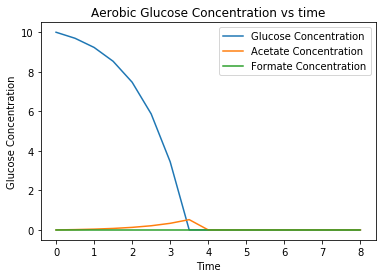

In [6]:
import matplotlib.pyplot as plt

times2 = [x/100 for x in range(0,100,1)]
x = time
y = glucose_concentration
  
# plotting the points 
plt.plot(x, glucose_concentration, label = "Glucose Concentration")
plt.plot(x, acetate_concentration, label = "Acetate Concentration")
plt.plot(x, formate_concentration, label = "Formate Concentration")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Glucose Concentration')
  
# giving a title to my graph
plt.title('Aerobic Glucose Concentration vs time')
  
# function to show the plot
plt.legend()
plt.show()

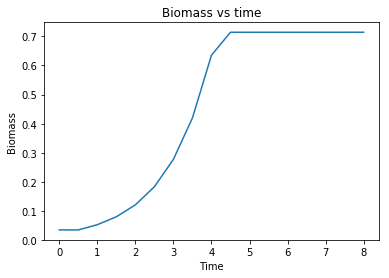

In [7]:
import matplotlib.pyplot as plt

times2 = [x/100 for x in range(0,500,5)]
x = time
y = biomass
  
# plotting the points 
plt.plot(x, y, label = "Time")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Biomass')
  
# giving a title to my graph
plt.title('Biomass vs time')
  
# function to show the plot
plt.show()

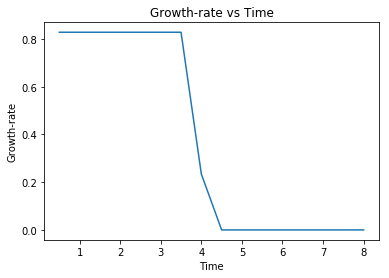

In [8]:
x1 = time[1:]
y = mu_results
  
# plotting the points 
plt.plot(x1, y, label = "Time")

# naming the x axis
plt.xlabel('Time')
# naming the y axis
plt.ylabel('Growth-rate')
  
# giving a title to my graph
plt.title('Growth-rate vs Time')
  
# function to show the plot
plt.show()